# Maximum Likelihood Estimation (Generic models)

This tutorial explains how to quickly implement new maximum likelihood models in `statsmodels`. We give two examples: 

1. Probit model for binary dependent variables
2. Negative binomial model for count data

The `GenericLikelihoodModel` class eases the process by providing tools such as automatic numeric differentiation and a unified interface to ``scipy`` optimization functions. Using ``statsmodels``, users can fit new MLE models simply by "plugging-in" a log-likelihood function. 

## Example 1: Probit model

In [1]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

The ``Spector`` dataset is distributed with ``statsmodels``. You can access a vector of values for the dependent variable (``endog``) and a matrix of regressors (``exog``) like this:

In [2]:
data = sm.datasets.spector.load_pandas()
exog = data.exog
endog = data.endog
print(sm.datasets.spector.NOTE)
print(data.exog.head())

::

    Number of Observations - 32

    Number of Variables - 4

    Variable name definitions::

        Grade - binary variable indicating whether or not a student's grade
                improved.  1 indicates an improvement.
        TUCE  - Test score on economics test
        PSI   - participation in program
        GPA   - Student's grade point average

    GPA  TUCE  PSI
0  2.66  20.0  0.0
1  2.89  22.0  0.0
2  3.28  24.0  0.0
3  2.92  12.0  0.0
4  4.00  21.0  0.0


Them, we add a constant to the matrix of regressors:

In [5]:
exog = sm.add_constant(exog, prepend=True)
print(exog.head())

   const   GPA  TUCE  PSI
0    1.0  2.66  20.0  0.0
1    1.0  2.89  22.0  0.0
2    1.0  3.28  24.0  0.0
3    1.0  2.92  12.0  0.0
4    1.0  4.00  21.0  0.0


0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: GRADE, dtype: float64


Matplotlib is building the font cache; this may take a moment.
Fontconfig warning: ignoring UTF-8: not a valid region tag


<Axes: >

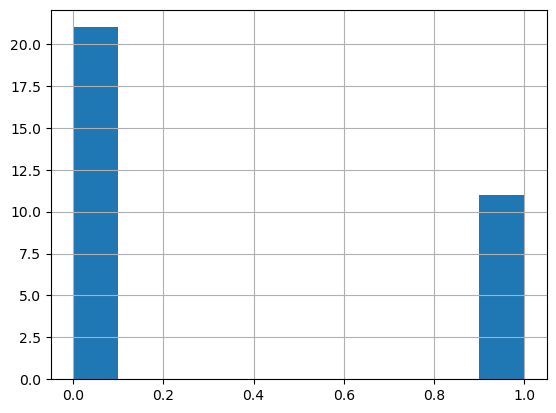

In [9]:
# inspect endogenous variable
print(endog.head())
# print histogram of endogenous variable
endog.hist()

To create your own Likelihood Model, you simply need to overwrite the loglike method.

In [10]:
# defining a child class MyProbit that inherits the parent GenericLikelihoodModel
# likelihood function using transformed outcome variable (original in example notebook)
class MyProbit(GenericLikelihoodModel):
    def loglike(self, params):
        exog = self.exog
        endog = self.endog
        q = 2 * endog - 1  # transforms 0,1 -> -1,1
        return stats.norm.logcdf(q*np.dot(exog, params)).sum()

The log-likelihood function for the probit model with outcome $y_i \in \{0,1\}$ is:
\begin{align*}
\ln L(\beta) = \sum_{i=1}^n \Big[ y_i \ln \Phi(x_i'\beta) + (1-y_i) \ln (1-\Phi(x_i'\beta)) \Big]
\end{align*}

The tranformed log-likelihood function with outcome $q_i = 2y_i - 1$ with $q_i \in \{-1,1\}$ is:
\begin{align*}
\ln L(\beta) = \sum_{i=1}^n \Big[ \ln \Phi(q_i * x_i'\beta) \Big]
\end{align*}

 This transformed log-likelihood function is equivalent to the original. When $y_i=1$, $q_i = 1$, thus the log-likelihood is $\ln\Phi(x_i'\beta)$ in both functions. When $y_i=0$, $q_i = -1$, the original log-likelihood is $\ln(1-\Phi(x_i'\beta))$, which is equivalent to $\ln\Phi(-x_i'\beta)$ in the transformed function, because $\Phi(-x_i'\beta) = 1 - \Phi(x_i'\beta)$ by symmetry of the normal distribution.

In [30]:
# original likelihood function using binary outcome variable
class MyProbit2(GenericLikelihoodModel):
    def loglike(self, params):
        exog = self.exog
        endog = self.endog
        return (endog*np.log(stats.norm.cdf(np.dot(exog, params))) + (1-endog)*np.log(1 - stats.norm.cdf(np.dot(exog, params)))).sum()

Estimate the model and print a summary:

In [11]:
sm_probit_manual = MyProbit(endog, exog).fit()
print(sm_probit_manual.summary())

Optimization terminated successfully.
         Current function value: 0.400588
         Iterations: 292
         Function evaluations: 494
                               MyProbit Results                               
Dep. Variable:                  GRADE   Log-Likelihood:                -12.819
Model:                       MyProbit   AIC:                             33.64
Method:            Maximum Likelihood   BIC:                             39.50
Date:                Thu, 08 Jun 2023                                         
Time:                        20:57:44                                         
No. Observations:                  32                                         
Df Residuals:                      28                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [31]:
sm_probit_manual2 = MyProbit2(endog, exog).fit()
print(sm_probit_manual2.summary())

Optimization terminated successfully.
         Current function value: 0.400588
         Iterations: 292
         Function evaluations: 494
                              MyProbit2 Results                               
Dep. Variable:                  GRADE   Log-Likelihood:                -12.819
Model:                      MyProbit2   AIC:                             33.64
Method:            Maximum Likelihood   BIC:                             39.50
Date:                Thu, 08 Jun 2023                                         
Time:                        21:07:38                                         
No. Observations:                  32                                         
Df Residuals:                      28                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

Compare your Probit implementation to ``statsmodels``' "canned" implementation:

In [13]:
sm_probit_canned = sm.Probit(endog, exog).fit()
print(sm_probit_canned.summary())

Optimization terminated successfully.
         Current function value: 0.400588
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                  GRADE   No. Observations:                   32
Model:                         Probit   Df Residuals:                       28
Method:                           MLE   Df Model:                            3
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                  0.3775
Time:                        20:58:22   Log-Likelihood:                -12.819
converged:                       True   LL-Null:                       -20.592
Covariance Type:            nonrobust   LLR p-value:                  0.001405
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.4523      2.542     -2.931      0.003     -12.435      -2.469
GPA            1.6258      0.

In [15]:
print(sm_probit_canned.params)
print(sm_probit_manual.params)

const   -7.452320
GPA      1.625810
TUCE     0.051729
PSI      1.426332
dtype: float64
[-7.45233176  1.62580888  0.05172971  1.42631954]


In [16]:
print(sm_probit_canned.cov_params())
print(sm_probit_manual.cov_params())

          const       GPA      TUCE       PSI
const  6.464166 -1.169668 -0.101173 -0.594792
GPA   -1.169668  0.481473 -0.018914  0.105439
TUCE  -0.101173 -0.018914  0.007038  0.002472
PSI   -0.594792  0.105439  0.002472  0.354070
[[ 6.46416786e+00 -1.16966621e+00 -1.01173182e-01 -5.94789026e-01]
 [-1.16966621e+00  4.81472113e-01 -1.89134568e-02  1.05438229e-01]
 [-1.01173182e-01 -1.89134568e-02  7.03758372e-03  2.47189301e-03]
 [-5.94789026e-01  1.05438229e-01  2.47189301e-03  3.54069514e-01]]


Notice that the ``GenericMaximumLikelihood`` class provides automatic differentiation, so we did not have to provide Hessian or Score functions in order to calculate the covariance estimates.



## Example 2: Negative Binomial Regression for Count Data

Consider a negative binomial regression model for count data with
log-likelihood (type NB-2) function expressed as:

$$
    \mathcal{L}(\beta_j; y, \alpha) = \sum_{i=1}^n y_i ln 
    \left ( \frac{\alpha \overbrace{exp(X_i'\beta)}^{\mu:=}}{1+\alpha exp(X_i'\beta)} \right ) -
    \frac{1}{\alpha} ln(1+\alpha exp(X_i'\beta)) + ln \Gamma (y_i + 1/\alpha) - ln \Gamma (y_i+1) - ln \Gamma (1/\alpha)
$$

with a matrix of regressors $X$, a vector of coefficients $\beta$,
and the negative binomial heterogeneity parameter $\alpha$. 

Using the ``nbinom`` distribution from ``scipy``, we can write this likelihood
simply as:


In [32]:
import numpy as np
from scipy.stats import nbinom

In [33]:
def _ll_nb2(y, X, beta, alph):
    mu = np.exp(np.dot(X, beta))
    size = 1/alph
    prob = size/(size+mu)
    ll = nbinom.logpmf(y, size, prob)
    return ll

### New Model Class

We create a new model class which inherits from ``GenericLikelihoodModel``:

In [34]:
from statsmodels.base.model import GenericLikelihoodModel

In [41]:
class NBin(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NBin, self).__init__(endog, exog, **kwds)
        
    def nloglikeobs(self, params):
        alph = params[-1]
        beta = params[:-1]
        ll = _ll_nb2(self.endog, self.exog, beta, alph)
        return -ll 
    
    # overwrite fit method inherited from GenericLikelihoodModel
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        # we have one additional parameter and we need to add it for summary
        self.exog_names.append('alpha')
        if start_params == None:
            # Reasonable starting values
            start_params = np.append(np.zeros(self.exog.shape[1]), .5)
            # intercept
            start_params[-2] = np.log(self.endog.mean())
        return super(NBin, self).fit(start_params=start_params, 
                                     maxiter=maxiter, maxfun=maxfun, 
                                     **kwds) 

Two important things to notice: 

+ ``nloglikeobs``: This function should return one evaluation of the negative log-likelihood function per observation in your dataset (i.e. rows of the endog/X matrix). 
+ ``start_params``: A one-dimensional array of starting values needs to be provided. The size of this array determines the number of parameters that will be used in optimization.
   
That's it! You're done!

### Usage Example

The [Medpar](https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/doc/COUNT/medpar.html)
dataset is hosted in CSV format at the [Rdatasets repository](https://raw.githubusercontent.com/vincentarelbundock/Rdatasets). We use the ``read_csv``
function from the [Pandas library](https://pandas.pydata.org) to load the data
in memory. We then print the first few columns: 


In [36]:
import statsmodels.api as sm

In [37]:
medpar = sm.datasets.get_rdataset("medpar", "COUNT", cache=True).data

medpar.head()

,los,hmo,white,died,age80,type,type1,type2,type3,provnum
0,4,0,1,0,0,1,1,0,0,30001
1,9,1,1,0,0,1,1,0,0,30001
2,3,1,1,1,1,1,1,0,0,30001
3,9,0,1,0,0,1,1,0,0,30001
4,1,0,1,1,1,1,1,0,0,30001


The model we are interested in has a vector of non-negative integers as
dependent variable (``los``), and 5 regressors: ``Intercept``, ``type2``,
``type3``, ``hmo``, ``white``.

For estimation, we need to create two variables to hold our regressors and the outcome variable. These can be ndarrays or pandas objects.

In [38]:
y = medpar.los
X = medpar[["type2", "type3", "hmo", "white"]].copy()
X["constant"] = 1


Then, we fit the model and extract some information: 

In [39]:
mod = NBin(y, X)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 3.209014
         Iterations: 805
         Function evaluations: 1238


/Users/lhe/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/lhe/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


 Extract parameter estimates, standard errors, p-values, AIC, etc.:

In [42]:
print('Parameters: ', res.params)
print('Standard errors: ', res.bse)
print('P-values: ', res.pvalues)
print('AIC: ', res.aic)

Parameters:  [ 0.2212642   0.70613942 -0.06798155 -0.12903932  2.31026565  0.44575147]
Standard errors:  [0.05059259 0.07613047 0.05326096 0.0685414  0.06794696 0.01981542]
P-values:  [1.22298084e-005 1.76979047e-020 2.01819053e-001 5.97481232e-002
 2.15207253e-253 4.62685274e-112]
AIC:  9604.95320583016


As usual, you can obtain a full list of available information by typing
``dir(res)``.
We can also look at the summary of the estimation results.

In [43]:
print(res.summary())

                                 NBin Results                                 
Dep. Variable:                    los   Log-Likelihood:                -4797.5
Model:                           NBin   AIC:                             9605.
Method:            Maximum Likelihood   BIC:                             9632.
Date:                Thu, 08 Jun 2023                                         
Time:                        23:16:27                                         
No. Observations:                1495                                         
Df Residuals:                    1490                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
type2          0.2213      0.051      4.373      0.000       0.122       0.320
type3          0.7061      0.076      9.275      0.0

### Testing

We can check the results by using the statsmodels implementation of the Negative Binomial model, which uses the analytic score function and Hessian.

In [44]:
res_nbin = sm.NegativeBinomial(y, X).fit(disp=0)
print(res_nbin.summary())

                     NegativeBinomial Regression Results                      
Dep. Variable:                    los   No. Observations:                 1495
Model:               NegativeBinomial   Df Residuals:                     1490
Method:                           MLE   Df Model:                            4
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                 0.01215
Time:                        23:16:35   Log-Likelihood:                -4797.5
converged:                       True   LL-Null:                       -4856.5
Covariance Type:            nonrobust   LLR p-value:                 1.404e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
type2          0.2212      0.051      4.373      0.000       0.122       0.320
type3          0.7062      0.076      9.276      0.000       0.557       0.855
hmo           -0.0680      0.053     -1.276      0.2

In [45]:
print(res_nbin.params)

type2       0.221218
type3       0.706173
hmo        -0.067987
white      -0.129053
constant    2.310279
alpha       0.445748
dtype: float64


In [46]:
print(res_nbin.bse)

type2       0.050592
type3       0.076131
hmo         0.053261
white       0.068541
constant    0.067947
alpha       0.019815
dtype: float64


Or we could compare them to results obtained using the MASS implementation for R:

    url = 'https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/csv/COUNT/medpar.csv'
    medpar = read.csv(url)
    f = los~factor(type)+hmo+white
    
    library(MASS)
    mod = glm.nb(f, medpar)
    coef(summary(mod))
                     Estimate Std. Error   z value      Pr(>|z|)
    (Intercept)    2.31027893 0.06744676 34.253370 3.885556e-257
    factor(type)2  0.22124898 0.05045746  4.384861  1.160597e-05
    factor(type)3  0.70615882 0.07599849  9.291748  1.517751e-20
    hmo           -0.06795522 0.05321375 -1.277024  2.015939e-01
    white         -0.12906544 0.06836272 -1.887951  5.903257e-02

### Numerical precision 

The ``statsmodels`` generic MLE and ``R`` parameter estimates agree up to the fourth decimal. The standard errors, however, agree only up to the second decimal. This discrepancy is the result of imprecision in our Hessian numerical estimates. In the current context, the difference between ``MASS`` and ``statsmodels`` standard error estimates is substantively irrelevant, but it highlights the fact that users who need very precise estimates may not always want to rely on default settings when using numerical derivatives. In such cases, it is better to use analytical derivatives with the ``LikelihoodModel`` class.